## [Webpage Version](https://olgabelitskaya.github.io/DL_PP2_Additional.html)
## Modules & Functions

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd
import h5py,tensorflow as tf,pylab as pl
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model,Model
from keras.layers import Input,UpSampling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import Dense,LSTM,GlobalAveragePooling2D
from keras.layers import Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D

Using TensorFlow backend.


In [2]:
def prepro(images,labels,n_class):
    x_train,x_test,y_train,y_test=\
    train_test_split(images,labels,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_train=x_train.astype('float32')/255
    x_test=x_test.astype('float32')/255
    y_train=y_train.astype('int32')
    y_test=y_test.astype('int32')    
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    cy_train=tf.keras.utils.to_categorical(y_train,n_class) 
    cy_valid=tf.keras.utils.to_categorical(y_valid,n_class)
    cy_test=tf.keras.utils.to_categorical(y_test,n_class)
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [cy_train.shape,cy_valid.shape,cy_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels','encoded labels'])
    display(df)
    return [[x_train,x_valid,x_test],
            [y_train,y_valid,y_test],
            [cy_train,cy_valid,cy_test]]
def display_10img(X,y,s):
    fig,ax=pl.subplots(figsize=(10,3),nrows=2,ncols=5,
                       sharex=True,sharey=True)
    ax=ax.flatten()
    for i in range(10):
        ax[i].imshow(X[i].reshape(s,s),cmap=pl.cm.Greys)
        ax[i].set_title(letters[int(y[i])])
    ax[0].set_xticks([]); ax[0].set_yticks([])
    pl.tight_layout()

## Data Loading & Prepocessing

,train,valid,test
images,"(11352, 32, 32, 1)","(1419, 32, 32, 1)","(1419, 32, 32, 1)"
labels,"(11352, 1)","(1419, 1)","(1419, 1)"
encoded labels,"(11352, 33)","(1419, 33)","(1419, 33)"


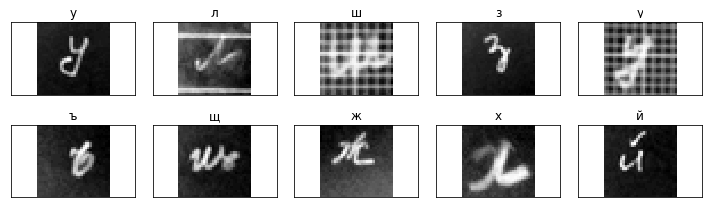

In [3]:
fpath='../input/classification-of-handwritten-letters/'
f=h5py.File(fpath+'LetterColorImages_123.h5','r') 
keys=list(f.keys())
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
images=np.array(f[keys[1]])/255
images=np.array(np.dot(images[...,:3],[.299,.587,.114])**2)\
       .reshape(-1,32,32,1)
labels=np.array(f[keys[2]]).reshape(-1,1)-1
[[x_train,x_valid,x_test],
 [y_train,y_valid,y_test],
 [cy_train,cy_valid,cy_test]]=\
prepro(images,labels,33)
display_10img(x_test,y_test,32)

## NN for Noise Reduction

In [4]:
def autoencoder():
    inputs=Input(shape=(32,32,1))
    # Encode
    x=Conv2D(24,7,padding='same')(inputs)
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(padding='same')(x)    
#    x=Conv2D(16,5,padding='same')(x)
#    x=LeakyReLU(alpha=.02)(x)
#    x=MaxPooling2D(padding='same')(x)    
    x=Conv2D(8,7,padding='same')(x)
    x=LeakyReLU(alpha=.02)(x)
    encoded=MaxPooling2D(padding='same')(x)        
    # Decode
    x=Conv2D(8,7,padding='same')(encoded)
    x=LeakyReLU(alpha=.02)(x)
    x=UpSampling2D()(x)   
#    x=Conv2D(16,5,padding='same')(x)
#    x=LeakyReLU(alpha=.02)(x)
#    x=UpSampling2D()(x)  
    x=Conv2D(24,7,padding='same')(x) 
    x=LeakyReLU(alpha=.02)(x)
    x=UpSampling2D()(x)    
    decoded=Conv2D(1,3,activation='sigmoid',
                   padding='same')(x)    
    # Autoencoder
    autoencoder=Model(inputs,decoded)
    autoencoder.compile(optimizer='nadam',loss='binary_crossentropy')    
    return autoencoder

In [5]:
autoencoder=autoencoder() 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        1200      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 24)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         9416      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
__________

In [6]:
history=autoencoder.fit(x_train,x_train, 
                        epochs=200,batch_size=64,verbose=2,
                        validation_data=(x_valid,x_valid))

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 11s - loss: 0.0368 - val_loss: 0.0115
Epoch 2/200
 - 2s - loss: 0.0114 - val_loss: 0.0113
Epoch 3/200
 - 2s - loss: 0.0112 - val_loss: 0.0112
Epoch 4/200
 - 2s - loss: 0.0110 - val_loss: 0.0109
Epoch 5/200
 - 2s - loss: 0.0109 - val_loss: 0.0109
Epoch 6/200
 - 2s - loss: 0.0109 - val_loss: 0.0108
Epoch 7/200
 - 2s - loss: 0.0109 - val_loss: 0.0110
Epoch 8/200
 - 2s - loss: 0.0108 - val_loss: 0.0111
Epoch 9/200
 - 2s - loss: 0.0108 - val_loss: 0.0108
Epoch 10/200
 - 2s - loss: 0.0108 - val_loss: 0.0108
Epoch 11/200
 - 2s - loss: 0.0108 - val_loss: 0.0108
Epoch 12/200
 - 2s - loss: 0.0108 - val_loss: 0.0107
Epoch 13/200
 - 2s - loss: 0.0108 - val_loss: 0.0107
Epoch 14/200
 - 2s - loss: 0.0107 - val_loss: 0.0107
Epoch 15/200
 - 2s - loss: 0.0107 - val_loss: 0.0107
Epoch 16/200
 - 2s - loss: 0.0107 - val_loss: 0.0108
Epoch 17/200
 - 2s - loss: 0.0107 - val_loss: 0.0106
Epoch 18/200
 - 2s - loss: 0.0107 - val_loss: 0.0106
Epoch

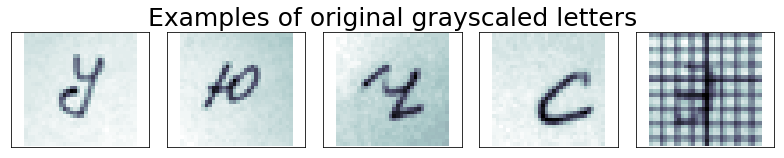

In [7]:
fig,ax=pl.subplots(figsize=(11,2),nrows=1,ncols=5,
                   sharex=True,sharey=True,)
ax=ax.flatten()
for i in range(5):
    img=x_test[i*10].reshape(32,32)
    ax[i].imshow(img,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout(); pl.gcf()
ax[2].set_title('Examples of original grayscaled letters',
                fontsize=25);

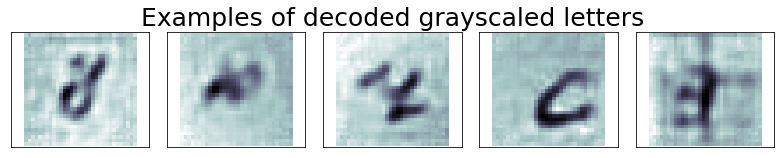

In [8]:
x_test_decoded=autoencoder.predict(x_test)
fig,ax=pl.subplots(figsize=(11,2),nrows=1,ncols=5,
                   sharex=True,sharey=True,)
ax=ax.flatten()
for i in range(5):
    image=x_test_decoded[i*10].reshape(32,32)
    ax[i].imshow(image,cmap=pl.cm.bone)
ax[0].set_xticks([]); ax[0].set_yticks([])
pl.tight_layout(); pl.gcf()
ax[2].set_title('Examples of decoded grayscaled letters',
                fontsize=25);